# **모델 학습**

강아지 피부질환 분류 문제

In [ ]:
%matplotlib inline

from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray

import imutils
import numpy as np
import argparse
import glob
import scipy
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import imageio

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
train_dir = '/content/train'
val_dir = '/content/val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
)
                                
val_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(224, 224),
                                                 batch_size=25,
                                                 class_mode='categorical')

val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size=(224, 224),
                                            batch_size=25,
                                            class_mode='categorical')

In [48]:
training_set.class_indices

{'A1_구진_플라크': 0,
 'A2_비듬_각질_상피성잔고리': 1,
 'A3_태선화_과다색소침착': 2,
 'A4_농포_여드름': 3,
 'A5_미란_궤양': 4,
 'A6_결절_종괴': 5}

In [49]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
import keras
import numpy as np
import tensorflow as tf
import os
import random

tf.random.set_seed(10)
np.random.seed(10) 
random.seed(10)
os.environ['PYTHONHASHSEED']=str(10)

In [50]:
num_classes = 6 #분류할 클래스의 수
input_shape = (224, 224, 3) #input size


model_pretrain = DenseNet121(weights='imagenet', 
                              include_top=False, 
                              input_shape=(224,224,3),
                              pooling='avg'
                             )  

#전이학습할 모델의 학습 프리징
model_pretrain.trainable = False

model = keras.Sequential([
    model_pretrain,
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
    ])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_22 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_23 (Dense)            (None, 6)                 12294     
                                                                 
Total params: 9,148,998
Trainable params: 2,111,494
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
# loss가 줄어들면 체크포인트 저장
cb_checkpointer = ModelCheckpoint(filepath="../models/checkpoint/%s_cnn_epoch{epoch:02d}-val_acc{val_accuracy:.2f}.h5" %(model_type), 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True,
                               mode='max'
                              )
#오버피팅 방지
cb_earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [ ]:
# 모델 컴파일
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer = 'adam')

nb_epochs = 200


# 모델 학습
hist = model.fit(training_set,
                  epochs=nb_epochs,
                  callbacks = [cb_checkpointer, cb_earlystop],
                  validation_data=val_set,
                  workers=4)

# **모델 테스트**


In [56]:
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

# 학습 모델 로드
model = tf.keras.models.load_model('/content/drive/MyDrive/models/skin-type/basic_cnn_epoch01-val_acc81.3.h5')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_22 (Dense)            (None, 2048)              2099200   
                                                                 
 dense_23 (Dense)            (None, 6)                 12294     
                                                                 
Total params: 9,148,998
Trainable params: 2,111,494
Non-trainable params: 7,037,504
_________________________________________________________________


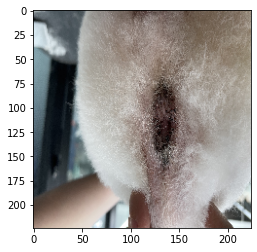

(1, 224, 224, 3)


In [60]:
# 테스트 이미지 로드
img_path = '/content/train/A1_구진_플라크/IMG_D_A1_000001.jpg'
img = load_img(img_path, target_size=(224, 224))

# 이미지를 input size로 변경
img = img_to_array(img)
img /= 255.
img = np.expand_dims(img, axis=0)

# 이미지 확인
plt.imshow(img[0])
plt.show()
print(img.shape)

In [61]:
pred = model.predict(img)[0]
pos = np.argmax(pred)

# 분류
classes = training_set.class_indices
for c in classes.keys():
    print('The probabiliy of this image being class %s:%s' %(c, pred[classes[c]]))

# 분류한 라벨 출력
for c in classes.keys():
    if classes[c] == pos:
        print('The predicted class is therefore:', c)

1/1 [==============================] - 2s 2s/step
The probabiliy of this image being class A1_구진_플라크:0.9740263
The probabiliy of this image being class A2_비듬_각질_상피성잔고리:0.0043499125
The probabiliy of this image being class A3_태선화_과다색소침착:0.002374452
The probabiliy of this image being class A4_농포_여드름:0.00043850474
The probabiliy of this image being class A5_미란_궤양:0.0004977725
The probabiliy of this image being class A6_결절_종괴:0.018312952
The predicted class is therefore: A1_구진_플라크
